# Looking into the score distributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

## Load user distinction

In [24]:
datasetName = 'Yelp'

In [25]:
from Data.loadDatasetFiles import loadDatasetFiles
from Data.readDataSizes import readDataSizes
from Models.utils import readTrainingData

datasetFiles = loadDatasetFiles(datasetName)
dataDictionary = readDataSizes(datasetName, datasetFiles)
users, pois = dataDictionary['users'], dataDictionary['pois']
trainingMatrix, userCheckinCounts, poiCheckinCounts = readTrainingData(datasetFiles['train'], users['count'], pois['count'], False)

Loading Yelp dataset files ...
Yelp dataset files have been loaded for processing!
Reading the 'dataSize' file to prepare further processing...
Yelp dataset contains 7135 users, 16621 locations, and 595 categories!
Reading training data...
Setting threshold to median repeating POI ratio of 0.7
Setting threshold to 80th prc. of POI visits of 66.0


In [26]:
from Data.calculateActiveUsers import calculateActiveUsers

activeUsers = calculateActiveUsers(datasetName, datasetFiles['train'], saveToFile=False)
print(activeUsers.shape)

activeUsers.head()

Calculating active/inactive users for dataset Yelp ...
Calculating Yelp_Active_05Percent.txt ...
Calculating Yelp_Active_20Percent.txt ...
(7135, 1)


,active
user_id,
4017,True
2444,True
1508,True
1542,True
3954,True


In [27]:
poiCheckinCounts.head()

,checkins,short_head
poi_id,,
196,1596,True
3170,1297,True
1515,1277,True
1092,1085,True
1582,1085,True


## Getting data statistics

* user count
* POI count
* checkin count
* sparsity
* active/inactive
* long tail/short head
* long tail visits/short head visits

In [28]:
activeUsers.shape

(7135, 1)

In [29]:
print(f"| Users | POIs | Checkins | Sparsity |")
print(f"""| {users['count']} | {pois['count']} | {poiCheckinCounts.checkins.sum()} | {(100.0 * poiCheckinCounts.checkins.sum()) / (users['count'] * pois['count']):.2f}%""")

| Users | POIs | Checkins | Sparsity |
| 7135 | 16621 | 774320 | 0.65%


In [30]:
print(f"| Active/Inactive users | Long-tail/Short-head POIs | Long-tail/Short-head Checkins |")
print(f"""| {activeUsers[activeUsers.active].shape[0]}/{activeUsers[~activeUsers.active].shape[0]} | {poiCheckinCounts[~poiCheckinCounts.short_head].shape[0]}/{poiCheckinCounts[poiCheckinCounts.short_head].shape[0]} | {poiCheckinCounts[~poiCheckinCounts.short_head].checkins.sum()}/{poiCheckinCounts[poiCheckinCounts.short_head].checkins.sum()}""")

| Active/Inactive users | Long-tail/Short-head POIs | Long-tail/Short-head Checkins |
| 1427/5708 | 12413/3162 | 280255/494065


## Getting the set of POIs visited

In [19]:
poiCheckinCounts.loc[[1, 1, 1], 'checkins']

poi_id
1    1355
1    1355
1    1355
Name: checkins, dtype: int64

In [20]:
activeVisitedPois = np.unique(np.concatenate([np.nonzero(trainingMatrix[u]) for u in activeUsers[activeUsers.active].index], axis=1)[0])
inactiveVisitedPois = np.unique(np.concatenate([np.nonzero(trainingMatrix[u]) for u in activeUsers[~activeUsers.active].index], axis=1)[0])

In [21]:
activeVisitedPois.shape

(26954,)

In [22]:
inactiveVisitedPois.shape

(27911,)

In [23]:
activeVPCheckins = poiCheckinCounts.loc[activeVisitedPois, 'checkins']
inactiveVPCheckins = poiCheckinCounts.loc[inactiveVisitedPois, 'checkins']

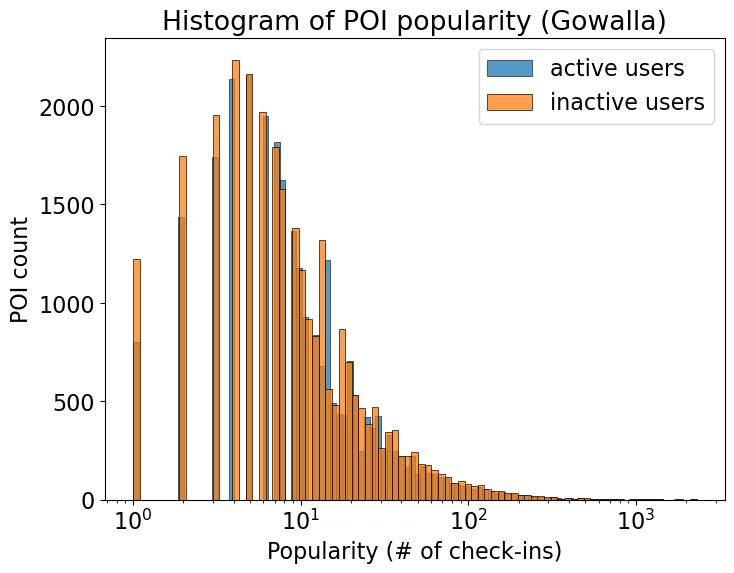

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(activeVPCheckins.values, log_scale=True, label='active users', ax=ax)
sns.histplot(inactiveVPCheckins.values, log_scale=True, label='inactive users', ax=ax)
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('POI count')
ax.legend()
ax.set_title(f'Histogram of POI popularity ({datasetName})')
fig.savefig(f'images/poi-popularity-histogram-{datasetName}.png')

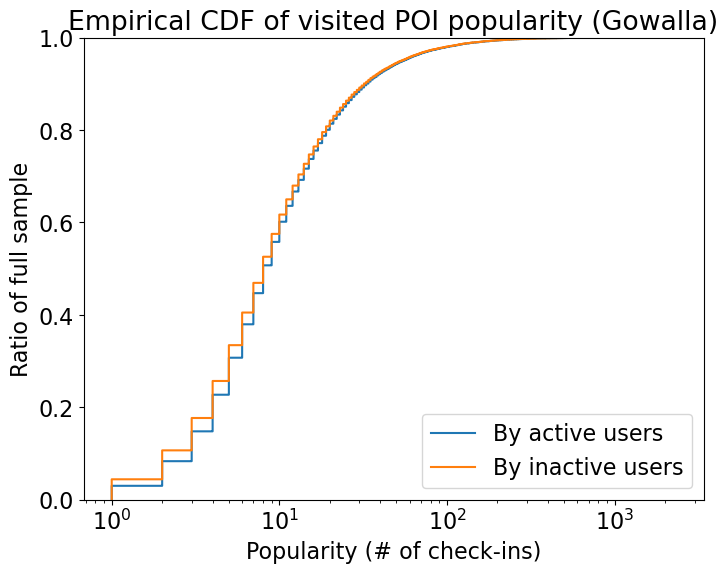

In [25]:

    plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8,6))
sns.ecdfplot(activeVPCheckins.values, log_scale=True, label='By active users', ax=ax)
sns.ecdfplot(inactiveVPCheckins.values, log_scale=True, label='By inactive users', ax=ax)
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('Ratio of full sample')
ax.legend()
ax.set_title(f'Empirical CDF of visited POI popularity ({datasetName})')
fig.savefig(f'images/poi-popularity-ecdf-{datasetName}.png')

/tmp/ipykernel_2033/344757012.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


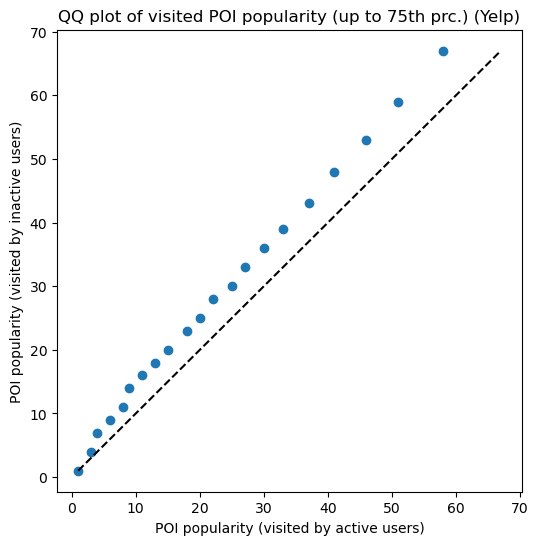

In [91]:
percs = np.linspace(0,75,21)
qn_active = np.percentile(activeVPCheckins.values, percs)
qn_inactive = np.percentile(inactiveVPCheckins.values, percs)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(qn_active,qn_inactive, ls="", marker="o")

x = np.linspace(
    np.min((qn_active.min(),qn_inactive.min())),
    np.max((qn_active.max(),qn_inactive.max()))
)
ax.plot(x,x, color="k", ls="--")
# ax.set_xlim(0, 200)
# ax.set_ylim(0, 200)
ax.set_xlabel('POI popularity (visited by active users)')
ax.set_ylabel('POI popularity (visited by inactive users)')
ax.set_title(f'QQ plot of visited POI popularity (up to 75th prc.) ({datasetName})')
fig.savefig(f'images/poi-popularity-qq-{datasetName}.png')

fig.show()

Yelp: inactive users tend to visit more popular POIs

Gowalla: nope